## GAN Demos - unit circle data

In [1]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


- **Data Preparation** Define datasets and data loaders.

In [2]:
import math
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np


torch.manual_seed(111)
def gen_sin(n_samples=1000):
    data = np.zeros((n_samples, 2))
    data[:,0] = 2*math.pi*(np.random.rand(n_samples)-0.5)
    data[:,1] = np.sin(data[:,0])
    return data
def gen_circle(n_samples=1000):
    data = np.zeros((n_samples,2))
    theta = 2*math.pi*np.random.rand(n_samples)
    data[:,0] = np.cos(theta)
    data[:,1] = np.sin(theta)
    return data

class DatasetGAN(Dataset):
    def __init__(self,x):
        self.x = torch.from_numpy(x.astype(np.float32))
        self.y = torch.ones(x.shape[0]).view(-1,1)
        self.n_samples = x.shape[0]
    def __getitem__(self,index):
        return self.x[index],self.y[index]
    
    def __len__(self):
        return self.n_samples

### Model Training

#### Define generator and discriminator**

In [3]:
import torch.nn as nn
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
            #nn.Tanh()
        )

    def forward(self, x):
        output = self.model(x)
        return output

#### Define GAN

In [4]:
import torch
from torch.optim import Adam,SGD
import matplotlib.pyplot as plt
import copy
from functools import partial

class GAN:
    def __init__(self,generator,discriminator):
        self.model = (generator,discriminator)
        self.criterion = nn.BCELoss()
        self.models = []
        
    @staticmethod   
    def _loss(g, d, X):
        criterion = nn.BCELoss()
        
        #generate latent space
        latent_space = torch.randn(X.shape)
        X_fake = g(latent_space)
        y_pred = d(X_fake)
        
        #generate loss contributed by fake data
        y = torch.zeros((y_pred.shape[0],1))
        loss = criterion(y_pred,y)        
        
        #generate loss contributed by real data
        y_pred = d(X)
        loss += criterion(y_pred,1-y)
        return loss
    
    def fit(self,train_loader,n_epochs=100, lr=0.001,output_epoch=20,print_epoch=False):
        generator, discriminator = self.model
        generator_optimizor = Adam(generator.parameters(), lr = lr)
        discriminator_optimizer = Adam(discriminator.parameters(), lr = lr)
        loss= self._loss
        # training loop
        for epoch in range(n_epochs):
            for (X, _) in train_loader:
                # train discriminator
                discriminator.zero_grad()
                loss(generator,discriminator,X).backward()
                discriminator_optimizer.step()
                # train generator
                generator_optimizor.zero_grad()                
                (-loss(generator,discriminator,X)).backward()
                generator_optimizor.step()
            
            if (epoch+1)%output_epoch ==0:
                if print_epoch:                
                    print(f'epoch {epoch+1}')
                self.models.append((epoch,copy.deepcopy(generator),copy.deepcopy(discriminator)))
                

#### Train GAN for circle data**

In [5]:
import time
start_time = time.time()
X = DatasetGAN(gen_circle())
train_loader = DataLoader(dataset=X, batch_size=50,shuffle=True)
gan = GAN(Generator(),Discriminator())
gan.fit(train_loader,n_epochs=300,output_epoch=5)
print("--- %s seconds ---" % (time.time() - start_time))

--- 28.03886389732361 seconds ---


### Results

#### Plot CDF of discrinimator score**

- **Generate data**

In [6]:
import numpy as np
import pandas as pd
n_samples=400
latent_space = torch.randn(n_samples,2)
def generate(df_real,models,g_idx):
    g = [model[1] for model in models][g_idx]
    df_fake = g(latent_space)

    probs_fake = [pd.Series(discriminator(df_fake).detach().numpy()[:,0]) for (epoch, _,discriminator) in models]
    probs_real = [pd.Series(discriminator(df_real).detach().numpy()[:,0]) for (epoch, _,discriminator) in models]
    return {'g_idx':g_idx,
            'probs_fake':probs_fake,
            'probs_real':probs_real}


models = [(epoch,generator,discrinimator) for (epoch,generator,discrinimator) in gan.models if epoch>4 and epoch<285]
probs_dicts = []
df_real = train_loader.dataset[:][0]
probs_dicts.append(generate(df_real,models,g_idx=5))
probs_dicts.append(generate(df_real,models,g_idx=10))
probs_dicts.append(generate(df_real,models,g_idx=45))


- **Generate animation**

MovieWriter imagemagick unavailable; using Pillow instead.


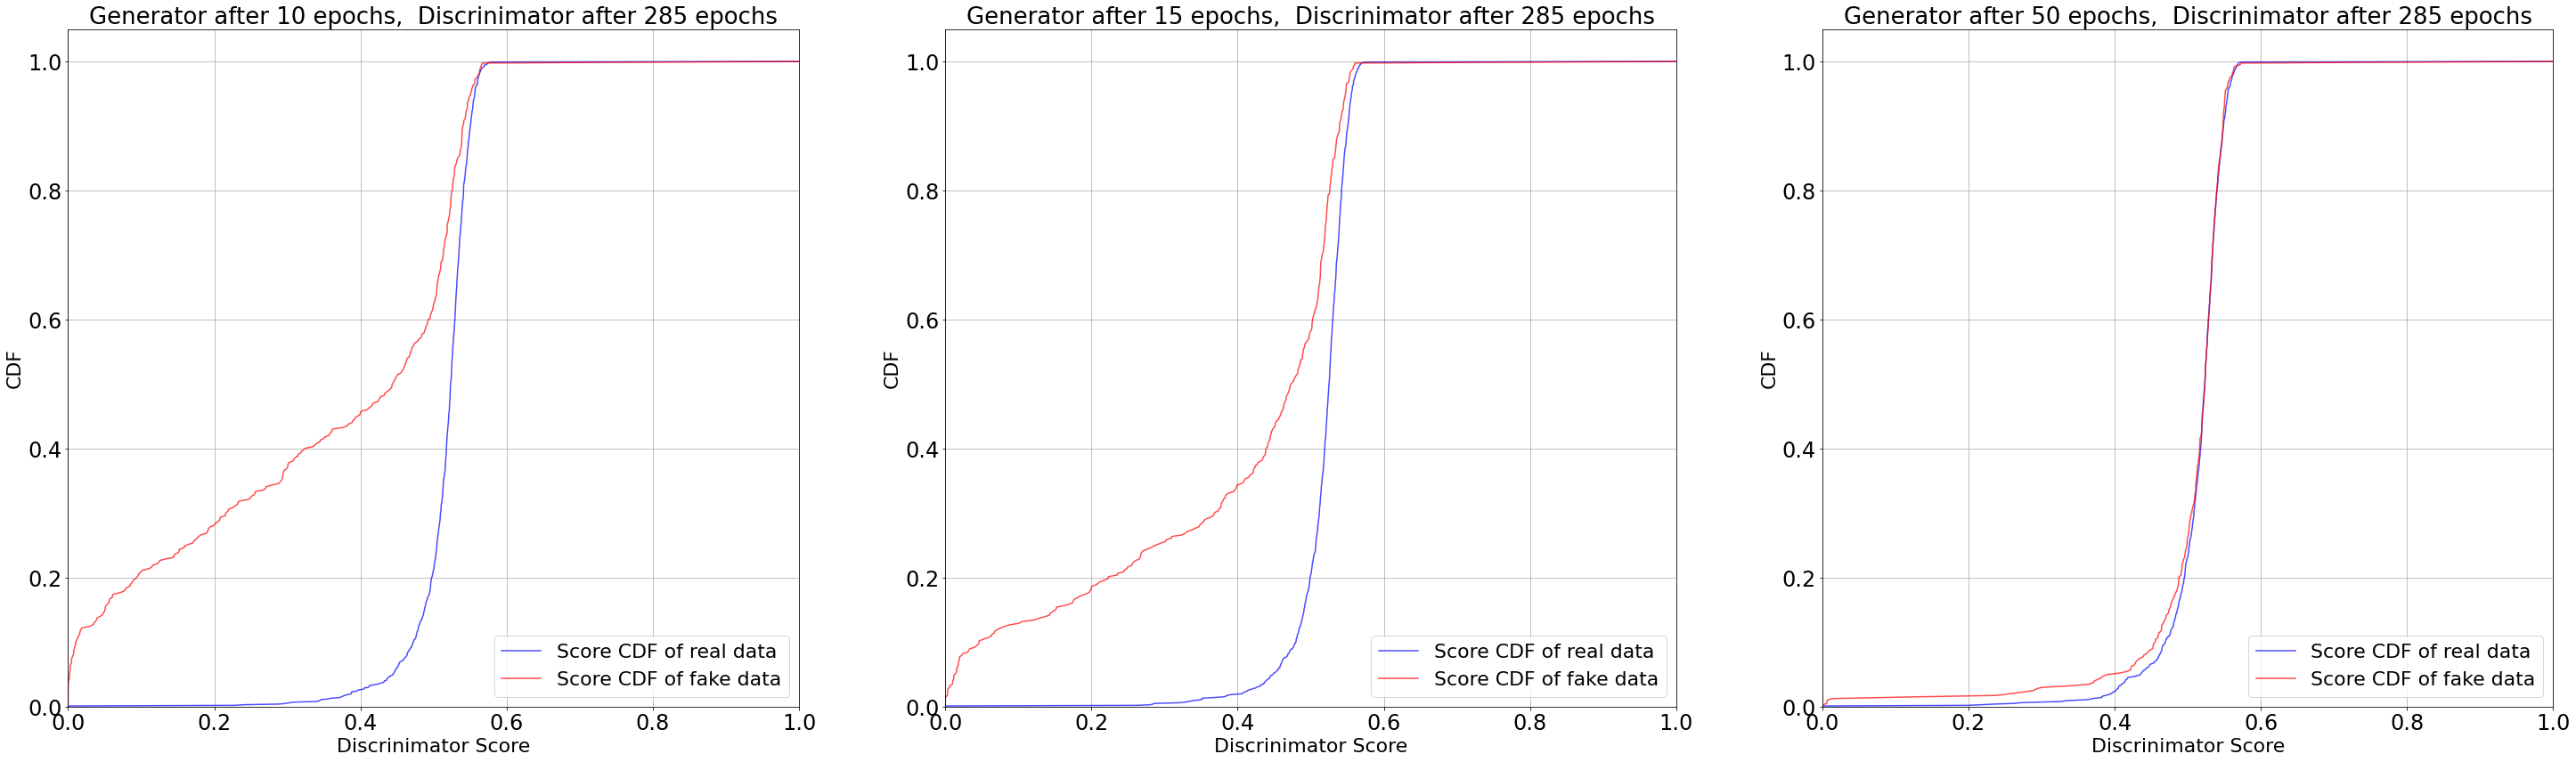

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.font_manager import FontProperties

font_props = FontProperties(size=24,weight='light')

def update(frame):
    
    for ax_idx,ax in enumerate(axs.reshape(-1)):
        probs_dict = probs_dicts[ax_idx]
        generator_idx = probs_dict['g_idx']+5
        probs_real = probs_dict['probs_real']
        probs_fake = probs_dict['probs_fake']
    
        ax.clear()
        ax.grid(True)

        p_real = np.sort(np.append(probs_real[frame],[0,1]))
        cdf_real = np.arange(1, len(p_real) + 1) / len(p_real)

        p_fake = np.sort(np.append(probs_fake[frame],[0,1]))
        cdf_fake = np.arange(1, len(p_fake) + 1) / len(p_fake)


        # Plot the CDF on the given axes
        ax.plot(p_real, cdf_real, color='blue', alpha=0.7,label='Score CDF of real data')
        ax.plot(p_fake, cdf_fake, color='red', alpha=0.7,label='Score CDF of fake data')
        ax.set_xlabel('Discrinimator Score',fontsize=22)
        ax.set_ylabel('CDF',fontsize=22)
        ax.legend(loc ='lower right',fontsize=22) 

        # Optionally set limits for x and y axis
        ax.set_xlim(0,1)
        ax.set_ylim(0, 1.05)


        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontproperties(font_props)
        if frame>=0:
            idx = (frame+1)*5+5
            ax.set_title(f'Generator after {generator_idx} epochs,  Discrinimator after {idx} epochs',fontsize=26)
        else:
            ax.set_title(f'Training',fontsize=26)
    
fig, axs = plt.subplots(figsize=(50,14),nrows=1, ncols=3)
#fig.suptitle('CDF of Discrinimator Scores', fontsize=30)
font_props = FontProperties(size=24,weight='light')
# Create the animation
ani = FuncAnimation(fig, update, frames=len(probs_dicts[0]['probs_fake']), interval=2000)

# Save the animation (optional)
ani.save('score_pdf_animation.gif', writer='imagemagick')

# Show the animation
plt.show()

#### Plot Real vs Fake data**

- **Generate data**

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.font_manager import FontProperties
# Example: Generating synthetic data for demonstration
# Replace this with your actual data

np.random.seed(0)
df_real = train_loader.dataset[:][0]

import torch

# Define the bounds of the rectangle
x_min, x_max = -1.5, 1.5
y_min, y_max = -1.5, 1.5

# Define the number of points along each axis
num_points_x = 50  # Number of points along x-axis
num_points_y = 50  # Number of points along y-axis

# Create evenly spaced points along x and y axes
x = torch.linspace(x_min, x_max, num_points_x)
y = torch.linspace(y_min, y_max, num_points_y)

# Create a meshgrid
X, Y = torch.meshgrid(x, y, indexing='ij')

# Flatten the grids and combine into a (num_points_x * num_points_y, 2) tensor
mesh = torch.stack([X.flatten(), Y.flatten()], dim=-1)

# Now 'points' is a PyTorch tensor with shape (num_points_x * num_points_y, 2)


def generate_classification(df_real,models,n_samples=400):
    latent_space = torch.randn(n_samples,2)
    fakes = [(epoch, g(latent_space),d) for (epoch, g,d) in models]
    
    probs_fake = [(epoch, np.concatenate((fake.detach().numpy(),
                                          d(fake).detach().numpy()[:,0:1]),
                                        axis=1))
                  for (epoch, fake,d) in fakes]

    
    probs_real = [(epoch,np.concatenate((df_real, d(df_real).detach().numpy()[:,0:1]),axis=1)) for (epoch, _,d) in models]
    probs_mesh = [(epoch,np.concatenate((mesh.numpy(),d(mesh).detach().numpy()[:,0:1]),axis=1)) for (epoch,_,d) in models]
    #dfs_fake = [df.numpy() for df in dfs_fake]
    return probs_fake,probs_real,probs_mesh

models = [(epoch,generator,discrinimator) for (epoch,generator,discrinimator) in gan.models if epoch>4 and epoch<285]
probs_fake,probs_real,probs_mesh = generate_classification(df_real,models)
print(len(probs_fake))
print(len(probs_real))
print(len(probs_mesh))
print(probs_mesh[0])

56
56
56
(9, array([[-1.5       , -1.5       ,  0.9828447 ],
       [-1.5       , -1.4387755 ,  0.5951231 ],
       [-1.5       , -1.3775511 ,  0.9787815 ],
       ...,
       [ 1.5       ,  1.3775511 ,  0.08621559],
       [ 1.5       ,  1.4387755 ,  0.4278564 ],
       [ 1.5       ,  1.5       ,  0.3283564 ]], dtype=float32))


- **Real vs Fake to animation**

MovieWriter imagemagick unavailable; using Pillow instead.


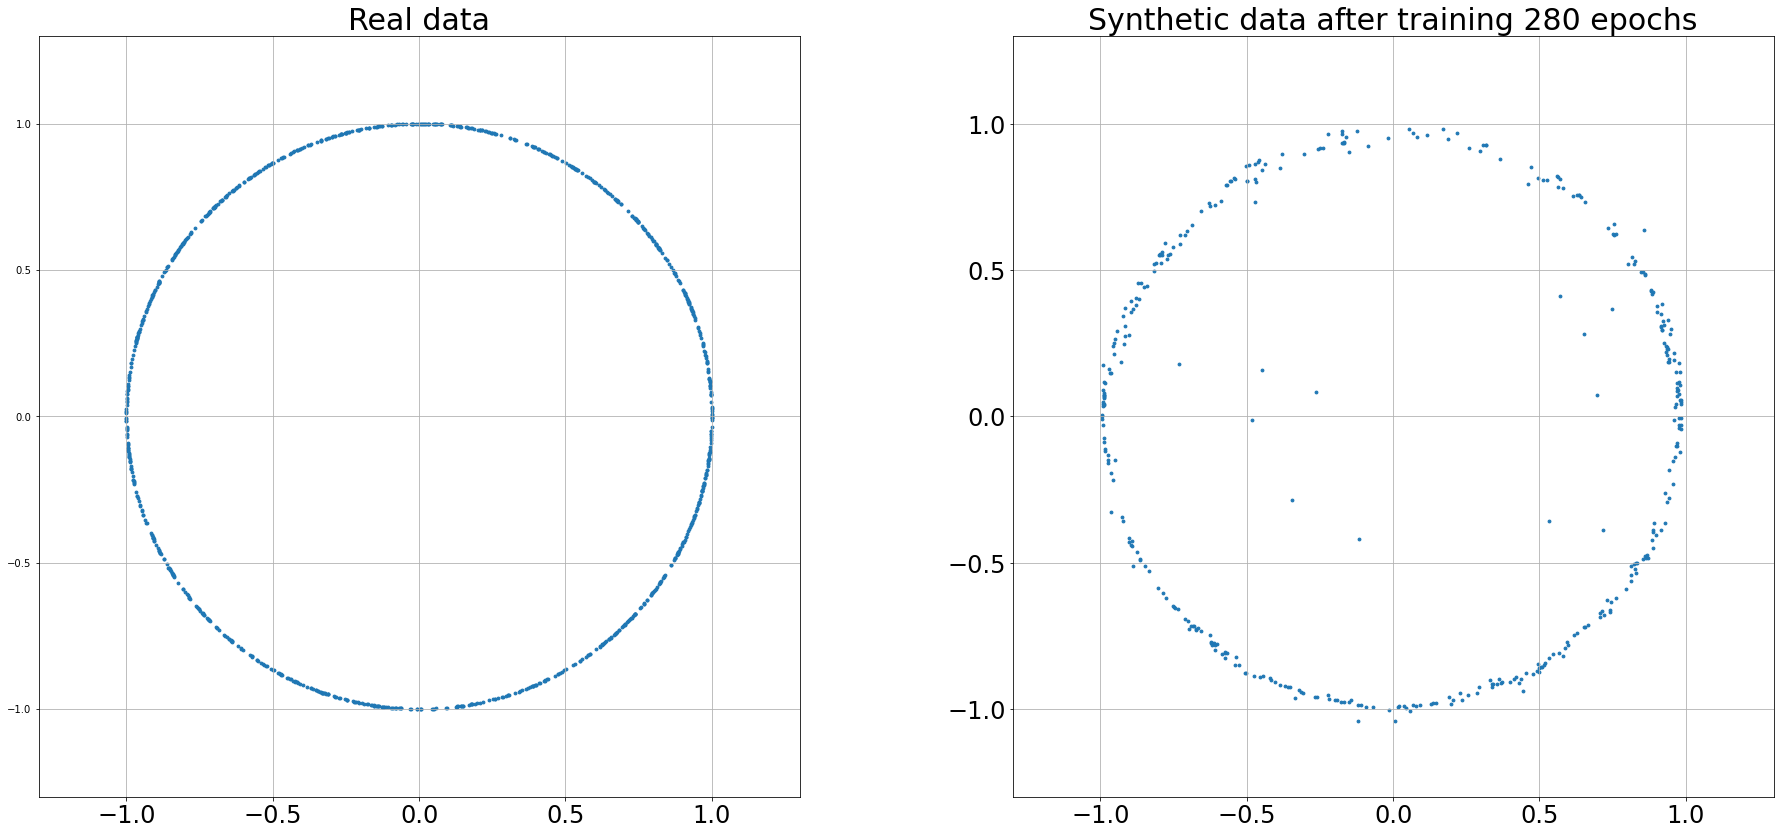

In [9]:
# Initialize the plot
fig, axs = plt.subplots(figsize=(32,14),nrows=1, ncols=2)
font_props = FontProperties(size=24,weight='light')

for ax in axs:
    # Set the plot limits
    ax.set_xlim(-1.3, 1.3)
    ax.set_ylim(-1.3, 1.3)
    ax.set_aspect('equal')
    ax.grid(True)
    ax.xaxis.set_tick_params(labelsize=24)
    
X = DatasetGAN(gen_circle())
real = X.x.numpy()    
axs[0].scatter(real[:,0],real[:,1],s=8)
axs[0].set_title(f'Real data',fontsize=30)

ax=axs[1]
scat = ax.scatter([], [])
# Update function for the animation
def update(frame):
    ax.clear()
    ax.grid(True)
    ax.set_xlim(-1.3, 1.3)
    ax.set_ylim(-1.3,1.3)
    
    epoch,df_fake = probs_fake[frame]
    scat = ax.scatter(df_fake[:, 0],df_fake[:, 1],s=8)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(font_props)
    if frame>=0:
        idx = (frame+1)*5
        ax.set_title(f'Synthetic data after training {idx} epochs',fontsize=30)
    return scat,

# Create the animation
ani = FuncAnimation(fig, update, frames=len(probs_fake), interval=2000, blit=True)

# Save the animation (optional)
ani.save('Real_vs_Fake_animation.gif', writer='imagemagick')

# Show the animation
plt.show()

- **Fake vs Real with inference to animiation**

MovieWriter imagemagick unavailable; using Pillow instead.


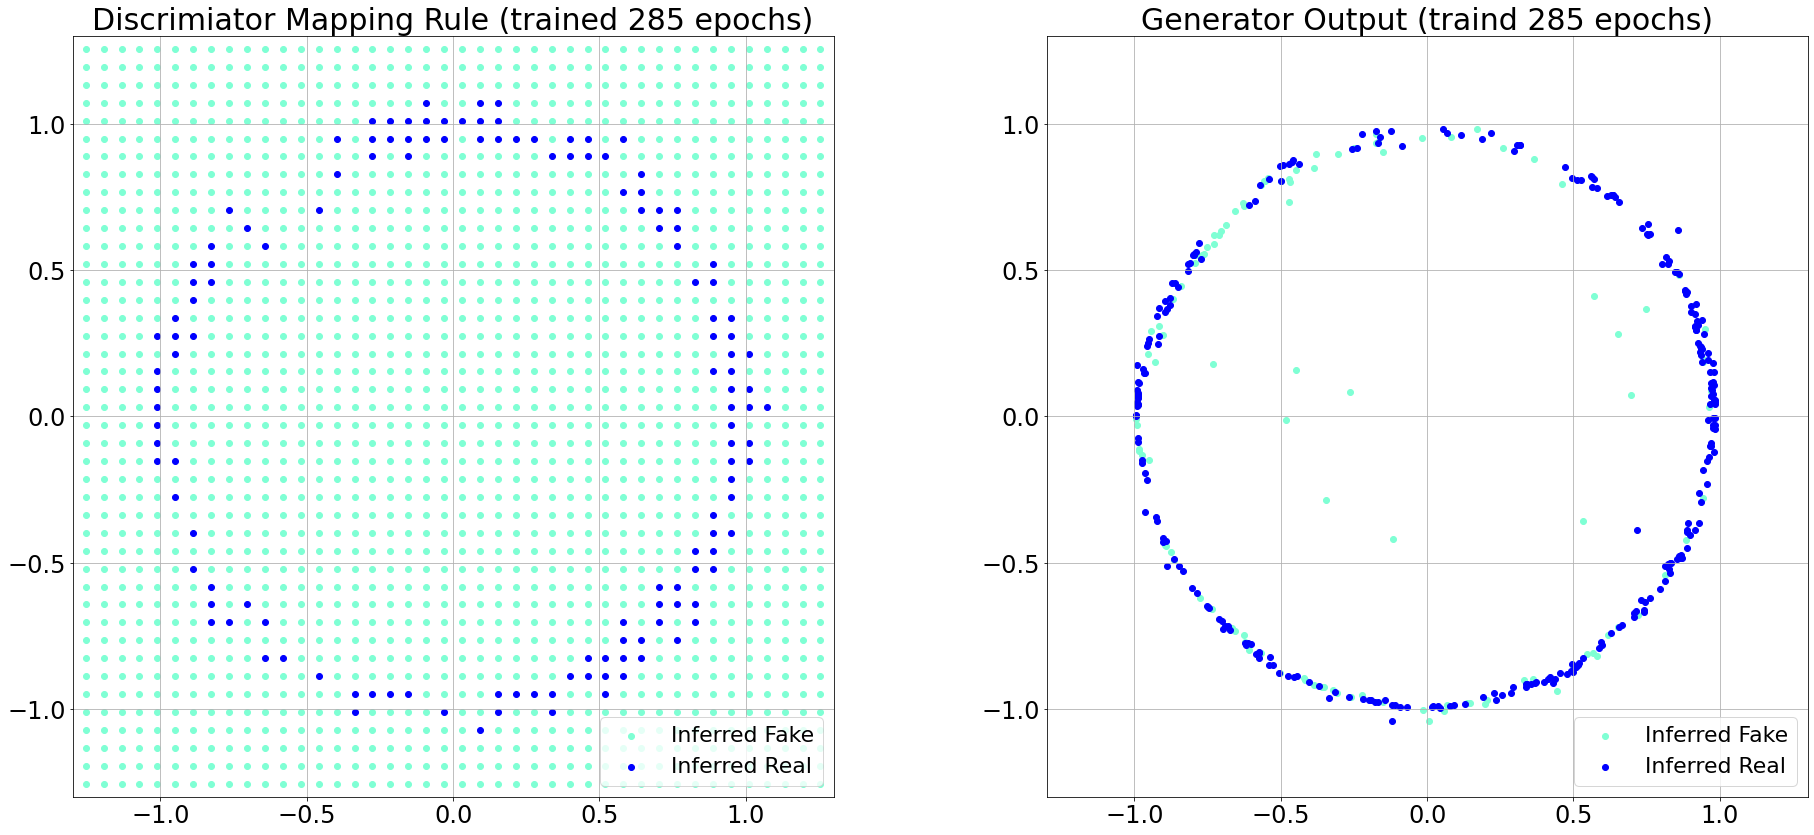

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.font_manager import FontProperties

fig, axs = plt.subplots(figsize=(32,14),nrows=1, ncols=2)


font_props = FontProperties(size=24,weight='light')
def plot_arr(ax, arr):
    ax.cla()
    ax.set_xlim(-1.3, 1.3)
    ax.set_ylim(-1.3, 1.3)
    ax.set_aspect('equal')
    ax.grid(True)
    ax.xaxis.set_tick_params(labelsize=24)
    x = arr[:,0]
    y = arr[:,1]
    labels = np.where(arr[:, 2]>0.5,1,0)
    
    
    ax.scatter(x[labels ==0],y[labels==0],c='aquamarine',label = 'Inferred Fake')
    ax.scatter(x[labels ==1],y[labels==1],c='blue',label = 'Inferred Real')
    ax.legend(loc ='lower right',fontsize=22) 
    
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(font_props)
    

scatter0 = axs[0].scatter([], [])
scatter1 = axs[1].scatter([], [])

def init():
    return axs
# Update function for the animation


def update(frame):
    
    epoch,arr = probs_mesh[frame]
    plot_arr(axs[0],arr)
    
    epoch,arr = probs_fake[frame]
    plot_arr(axs[1],arr)
    
    
    if frame>=0:
        idx = (frame+1)*5
        axs[0].set_title(f'Discrimiator Mapping Rule (trained {epoch+1} epochs)',fontsize=30)
        axs[1].set_title(f'Generator Output (traind {epoch+1} epochs)',fontsize=30)

    return axs
    
    

# Create the animation
ani = FuncAnimation(fig, update, frames=len(probs_real), init_func = init,interval=2000, blit=False)

# Save the animation (optional)
ani.save('Real_vs_Fake_inferred_animation.gif', writer='imagemagick')

# Show the animation
plt.show()

- **Fake vs Real Plots**

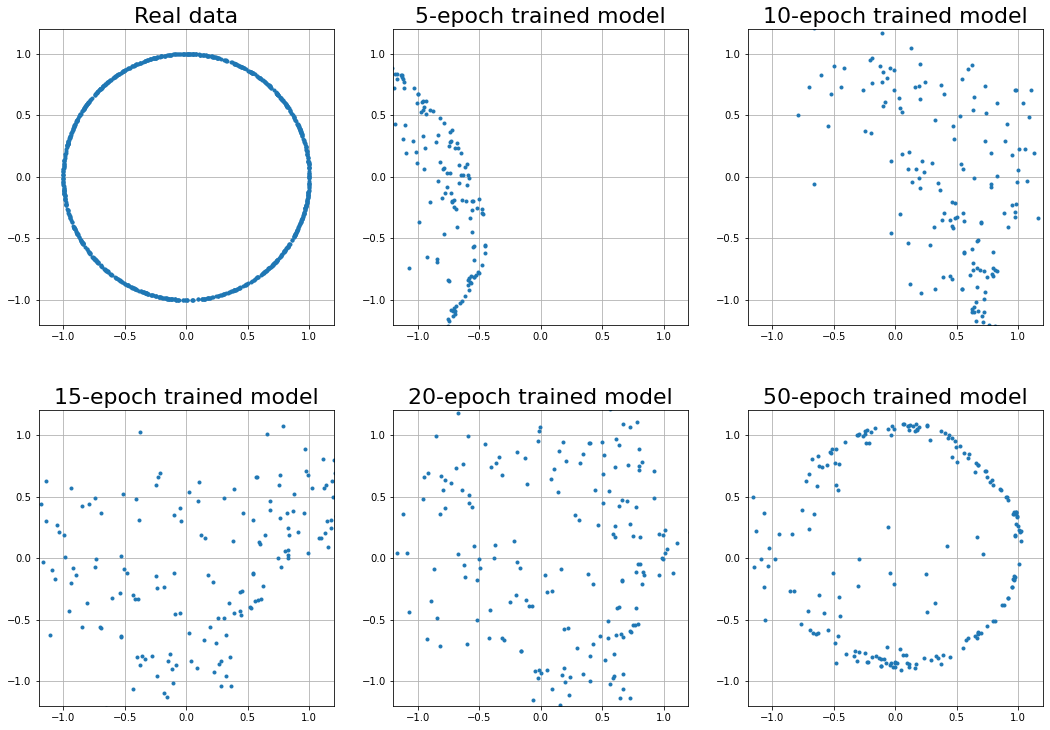

In [11]:
def plot(generators,X_real,n_samples=200,n_cols=3,fig_w=18,max_figures=5):
    latent_space = torch.randn(n_samples,X_real.shape[1])
    n = min(max_figures,len(generators))
    n_rows = math.ceil((n+1)/n_cols)

    fig,axes=plt.subplots(n_rows,n_cols)
    plt.gca().set_aspect('equal')
    fig_h =fig_w/2*n_rows/1.4
    _ = fig.set_size_inches((fig_w,fig_h))

    axes[0,0].plot(X_real[:,0],X_real[:,1],'.')
    axes[0,0].set_title('Real data',fontsize = 22)
    ax = axes[0,0]
    ax.grid(True)
    ax.set_xlim([-1.2, 1.2])
    ax.set_ylim([-1.2, 1.2])
    ax.set_aspect('equal')
    j=0
    for i,(epoch,generator) in enumerate(generators):
        if i in [0,1,2,3,9]:
            X_fake = generator(latent_space).detach().numpy()
            ax=plt.subplot(n_rows,n_cols,j+2)
            ax.grid(True)
            ax.plot(X_fake[:,0],X_fake[:,1],'.')
            ax.set_title(f'{epoch+1}-epoch trained model',fontsize = 22)
            ax.set_xlim([-1.2, 1.2])
            ax.set_ylim([-1.2, 1.2])
            ax.set_aspect('equal')
            j+=1
    return fig,axes
generators = [(i,g) for (i,g,d) in gan.models]
fig,axes = plot(generators,X_real=X[:,:][0].numpy(),n_samples=200)
plt.savefig('Real_vs_Fake.png')